#Loading Data


In [1]:
!pip install -q transformers datasets pandas accelerate evaluate bert_score nltk rouge_score textstat
import pandas as pd

In [2]:
df = pd.read_csv("amazon_stars.csv")

In [3]:
base_path = "/content/amazon_stars"


In [4]:
!pip install --upgrade --quiet torch torchvision torchaudio
!pip install --upgrade --quiet transformers sentence-transformers accelerate
!pip install --upgrade --quiet scikit-learn matplotlib seaborn tqdm pandas numpy


In [5]:
import os, re, json, math, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer


In [6]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [7]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff',
       'helpful_yes', 'total_vote'],
      dtype='object')

In [8]:
df.info()
print('---'*20)
print(df.describe())
print('---'*20)
print('Dataset shape:',df.shape)
print('---'*20)
print('Missing Values:')
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB
------------------------------------------------------------
           overall  unixReviewTime     day_diff  helpful_yes   total_vote
count  4915.000000    4.915000e+03  4915.000000  4915.000000  49

,0
reviewerName,1
reviewText,1
asin,0
reviewerID,0
helpful,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
day_diff,0


In [9]:
nan_per_column = df.isna().sum()
print("NaN values per column:")
print(nan_per_column)

# Total number of NaN values in the whole df
total_nan = df.isna().sum().sum()
print(f"\nTotal NaN values in DataFrame: {total_nan}")


NaN values per column:
reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

Total NaN values in DataFrame: 2


In [10]:
df = df.rename(columns={"overall": "star_rating"})

#Drop missing values

In [11]:
df_clean = df.dropna()
df_clean = df.dropna(how='all')
df_clean = df.dropna(subset=['star_rating'])
cols = ['star_rating']
df_clean = df.dropna(subset=cols)
df_clean = df_clean[(df_clean[cols] != '').all(axis=1)]



In [12]:
candidate_paths = [
    "/content/amazon_stars.csv",
]

df = None
for p in candidate_paths:
    if os.path.exists(p):
        if p.endswith(".parquet"):
            df = pd.read_parquet(p)
        else:
            df = pd.read_csv(p)
        print(f"Loaded: {p}  -> shape={df.shape}")
        break

if df is None:
    raise FileNotFoundError("⚠️ Please set the correct dataset path above (CSV or Parquet).")


Loaded: /content/amazon_stars.csv  -> shape=(4915, 12)


In [13]:
df_cols = set(df.columns.str.lower())

df.columns = [c.strip() for c in df.columns]

rating_col = None
for cand in ["overall", "rating", "stars", "star_rating"]:
    if cand in df.columns:
        rating_col = cand
        break

text_col = None
for cand in ["reviewText", "review_text", "text", "review", "body", "content", "reviews.text"]:
    if cand in df.columns:
        text_col = cand
        break

if rating_col is None or text_col is None:
    print("Available columns:", df.columns.tolist())
    raise ValueError("Could not auto-detect rating/text columns. Set them manually above.")

if rating_col != "star_rating":
    df = df.rename(columns={rating_col: "star_rating"})
if text_col != "review":
    df = df.rename(columns={text_col: "review"})


df["review"] = df["review"].astype(str).str.strip()
df = df[(df["review"].notna()) & (df["review"].str.len() > 0)]


df["star_rating"] = pd.to_numeric(df["star_rating"], errors="coerce").clip(1,5).astype("Int64")
df = df.dropna(subset=["star_rating"])
df = df.astype({"star_rating": int})

print(df[["review", "star_rating"]].head(3))
print("Shape after cleaning:", df.shape)


                                              review  star_rating
0                                         No issues.            4
1  Purchased this for my device, it worked as adv...            5
2  it works as expected. I should have sprung for...            4
Shape after cleaning: (4915, 12)


reviewerName      1
reviewerID        0
asin              0
helpful           0
review            0
star_rating       0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
dtype: int64
star_rating
1     244
2      80
3     142
4     527
5    3922
Name: count, dtype: int64


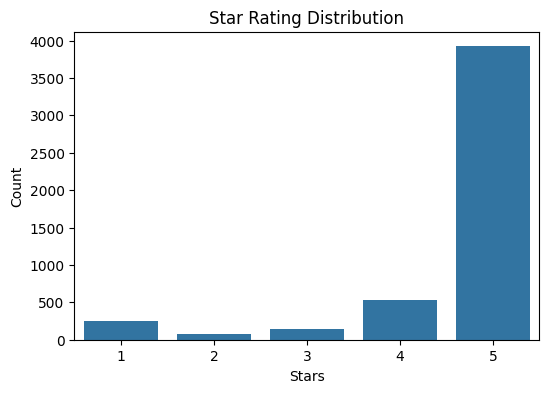

In [14]:
print(df.isna().sum().sort_values(ascending=False).head(10))
print(df["star_rating"].value_counts().sort_index())

plt.figure(figsize=(6,4))
sns.countplot(x=df["star_rating"])
plt.title("Star Rating Distribution")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()


In [15]:
df["label_mc"] = df["star_rating"]

bin_df = df[df["star_rating"] != 3].copy()
bin_df["label_bin"] = bin_df["star_rating"].apply(lambda r: 1 if r >= 4 else 0)

print("Multiclass shape:", df.shape)
print("Binary shape (3* removed):", bin_df.shape)
print(bin_df["label_bin"].value_counts())


Multiclass shape: (4915, 13)
Binary shape (3* removed): (4773, 14)
label_bin
1    4449
0     324
Name: count, dtype: int64


In [16]:
N_MC = min(6000, len(df))
N_BIN = min(6000, len(bin_df))

sample_mc = df.sample(N_MC, random_state=42) if len(df) > N_MC else df.copy()
sample_bin = bin_df.sample(N_BIN, random_state=42) if len(bin_df) > N_BIN else bin_df.copy()

print("sample_mc:", sample_mc.shape, "sample_bin:", sample_bin.shape)


sample_mc: (4915, 13) sample_bin: (4773, 14)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_mc["review"], sample_mc["label_mc"], test_size=0.2, random_state=42, stratify=sample_mc["label_mc"]
)

tfidf = TfidfVectorizer(
    max_features=40_000, ngram_range=(1,2), min_df=2
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

clf_mc = LogisticRegression(max_iter=200, n_jobs=None)
clf_mc.fit(Xtr, y_train)
pred_mc = clf_mc.predict(Xte)

print("Multiclass TF-IDF+LR")
print("Accuracy:", round(accuracy_score(y_test, pred_mc), 4))
print("Macro F1:", round(f1_score(y_test, pred_mc, average="macro"), 4))
print(classification_report(y_test, pred_mc))


Multiclass TF-IDF+LR
Accuracy: 0.8026
Macro F1: 0.2129
              precision    recall  f1-score   support

           1       0.56      0.10      0.17        49
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00       106
           5       0.80      1.00      0.89       784

    accuracy                           0.80       983
   macro avg       0.27      0.22      0.21       983
weighted avg       0.67      0.80      0.72       983



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [18]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    sample_bin["review"], sample_bin["label_bin"], test_size=0.2, random_state=42, stratify=sample_bin["label_bin"]
)

tfidf_b = TfidfVectorizer(
    max_features=40_000, ngram_range=(1,2), min_df=2
)
Xtr_b = tfidf_b.fit_transform(X_train_b)
Xte_b = tfidf_b.transform(X_test_b)

clf_bin = LinearSVC()
clf_bin.fit(Xtr_b, y_train_b)
pred_bin = clf_bin.predict(Xte_b)

print("Binary TF-IDF+LinearSVC")
print("Accuracy:", round(accuracy_score(y_test_b, pred_bin), 4))
print("Macro F1:", round(f1_score(y_test_b, pred_bin, average="macro"), 4))
print(classification_report(y_test_b, pred_bin, target_names=["neg","pos"]))


Binary TF-IDF+LinearSVC
Accuracy: 0.9634
Macro F1: 0.8136
              precision    recall  f1-score   support

         neg       0.94      0.49      0.65        65
         pos       0.96      1.00      0.98       890

    accuracy                           0.96       955
   macro avg       0.95      0.75      0.81       955
weighted avg       0.96      0.96      0.96       955



In [19]:
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
def embed_texts(texts, batch_size=128):
    return embed_model.encode(texts.tolist(), batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)

Xtr_emb = embed_texts(X_train)
Xte_emb = embed_texts(X_test)

clf_emb_mc = LogisticRegression(max_iter=500)
clf_emb_mc.fit(Xtr_emb, y_train)
pred_emb_mc = clf_emb_mc.predict(Xte_emb)

print("Multiclass Embeddings + LR")
print("Accuracy:", round(accuracy_score(y_test, pred_emb_mc), 4))
print("Macro F1:", round(f1_score(y_test, pred_emb_mc, average="macro"), 4))

Xtr_b_emb = embed_texts(X_train_b)
Xte_b_emb = embed_texts(X_test_b)

clf_emb_bin = LogisticRegression(max_iter=500)
clf_emb_bin.fit(Xtr_b_emb, y_train_b)
pred_emb_bin = clf_emb_bin.predict(Xte_b_emb)

print("Binary Embeddings + LR")
print("Accuracy:", round(accuracy_score(y_test_b, pred_emb_bin), 4))
print("Macro F1:", round(f1_score(y_test_b, pred_emb_bin, average="macro"), 4))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Multiclass Embeddings + LR
Accuracy: 0.8159
Macro F1: 0.2739


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Binary Embeddings + LR
Accuracy: 0.9529
Macro F1: 0.7508


In [20]:
device = 0 if torch.cuda.is_available() else -1
star_clf = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)

def bert_stars_to_int(label):
    # labels look like "1 star" or "5 stars"
    return int(label.split()[0])

eval_sample = sample_mc.sample(min(800, len(sample_mc)), random_state=3)  # small eval for speed
preds = []
for t in tqdm(eval_sample["review"].tolist()):
    res = star_clf(t, truncation=True)[0]
    preds.append(bert_stars_to_int(res["label"]))

print("Direct LLM (BERT 1–5 stars) — quick eval")
print("Accuracy:", round(accuracy_score(eval_sample["label_mc"], preds), 4))
print("Macro F1:", round(f1_score(eval_sample["label_mc"], preds, average="macro"), 4))
print(pd.crosstab(eval_sample["label_mc"], pd.Series(preds, name="pred")))


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 800/800 [03:15<00:00,  4.08it/s]


Direct LLM (BERT 1–5 stars) — quick eval
Accuracy: 0.6613
Macro F1: 0.4387
pred      1  2  3   4   5
label_mc                 
1         0  0  1   0   5
2         0  0  0   0   1
3         0  0  0   1   2
4         0  0  1   2   8
5         4  4  3  23  66


In [21]:
os.makedirs("/content/artifacts", exist_ok=True)

import joblib
joblib.dump(tfidf, "/content/artifacts/tfidf_mc.joblib")
joblib.dump(clf_mc, "/content/artifacts/logreg_mc.joblib")
joblib.dump(tfidf_b, "/content/artifacts/tfidf_bin.joblib")
joblib.dump(clf_bin, "/content/artifacts/linearsvc_bin.joblib")

report = {
    "mc_tfidf_acc": float(accuracy_score(y_test, pred_mc)),
    "mc_tfidf_macroF1": float(f1_score(y_test, pred_mc, average="macro")),
    "bin_svc_acc": float(accuracy_score(y_test_b, pred_bin)),
    "bin_svc_macroF1": float(f1_score(y_test_b, pred_bin, average="macro")),
}
with open("/content/artifacts/feasibility_metrics.json", "w") as f:
    json.dump(report, f, indent=2)

print("Saved to /content/artifacts")


Saved to /content/artifacts


In [28]:
import os
FIGDIR = "/content/figs"
os.makedirs(FIGDIR, exist_ok=True)
print("Saving figures to:", FIGDIR)


Saving figures to: /content/figs


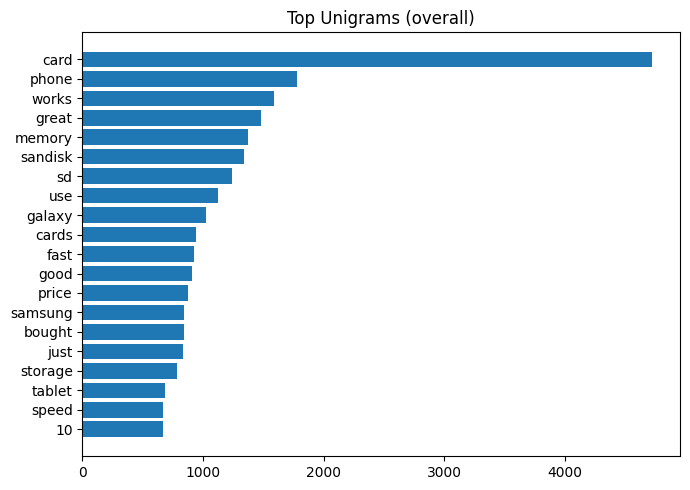

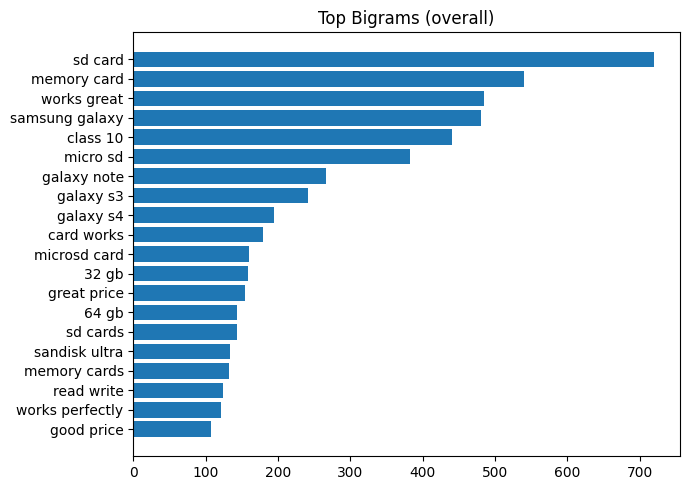

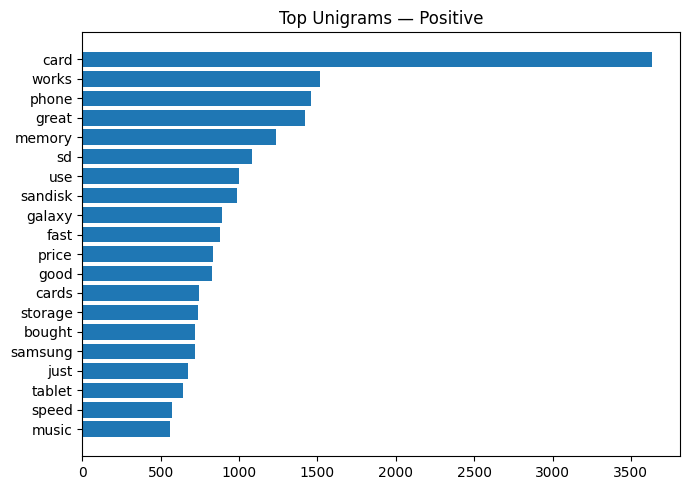

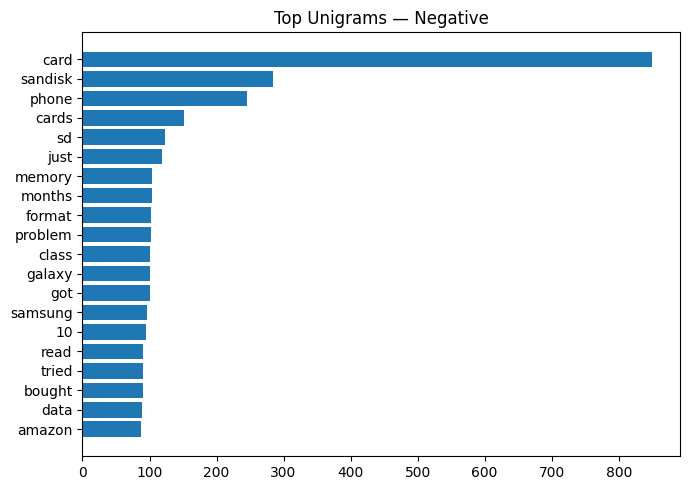

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def top_ngrams(texts, ngram_range=(1,1), topk=20, stop_words="english"):
    cv = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, min_df=2)
    X = cv.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(list(cv.vocabulary_.keys()))
    # cv.vocabulary_ is a dict token->index; invert carefully
    inv_vocab = np.array(sorted(cv.vocabulary_.items(), key=lambda kv: kv[1]))[:,0]
    pairs = list(zip(inv_vocab, freqs))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:topk]

def bar_from_pairs(pairs, title, fname):
    terms = [t for t,_ in pairs][::-1]
    counts = [c for _,c in pairs][::-1]
    plt.figure(figsize=(7,5))
    plt.barh(terms, counts)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{FIGDIR}/{fname}", dpi=150)
    plt.show()

# Overall top unigrams & bigrams
pairs_uni = top_ngrams(df["review"], (1,1), topk=20)
pairs_bi  = top_ngrams(df["review"], (2,2), topk=20)
bar_from_pairs(pairs_uni, "Top Unigrams (overall)", "top_unigrams_overall.png")
bar_from_pairs(pairs_bi,  "Top Bigrams (overall)",  "top_bigrams_overall.png")

# By sentiment (drop 3★)
bin_df = df[df.star_rating!=3].copy()
bin_df["sent"] = np.where(bin_df.star_rating>=4, "Positive", "Negative")

pairs_pos = top_ngrams(bin_df.loc[bin_df.sent=="Positive","review"], (1,1), topk=20)
pairs_neg = top_ngrams(bin_df.loc[bin_df.sent=="Negative","review"], (1,1), topk=20)
bar_from_pairs(pairs_pos, "Top Unigrams — Positive", "top_unigrams_pos.png")
bar_from_pairs(pairs_neg, "Top Unigrams — Negative", "top_unigrams_neg.png")


<Figure size 600x500 with 0 Axes>

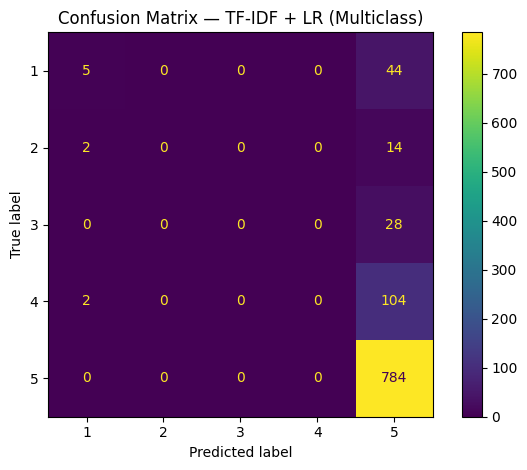

<Figure size 500x400 with 0 Axes>

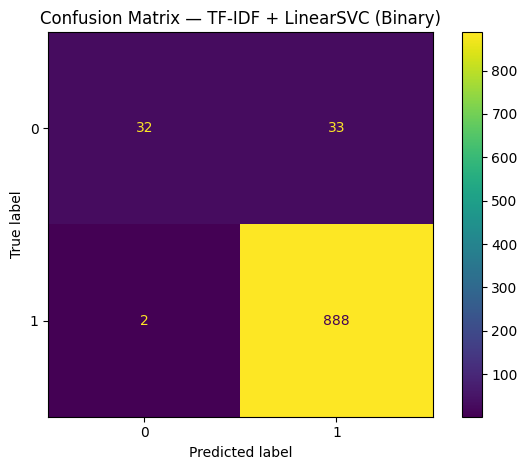

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

# Multiclass
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_mc)
plt.title("Confusion Matrix — TF-IDF + LR (Multiclass)")
plt.tight_layout()
plt.savefig(f"{FIGDIR}/cm_multiclass_tfidf_lr.png", dpi=150)
plt.show()

# Binary
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test_b, pred_bin)
plt.title("Confusion Matrix — TF-IDF + LinearSVC (Binary)")
plt.tight_layout()
plt.savefig(f"{FIGDIR}/cm_binary_tfidf_svc.png", dpi=150)
plt.show()


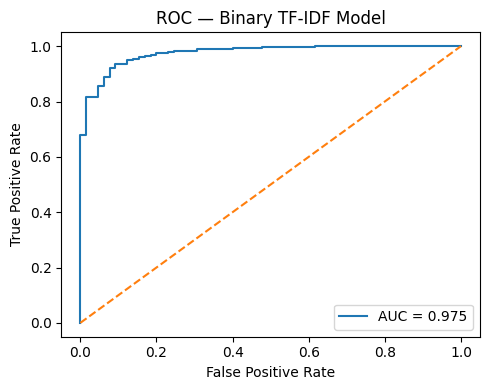

In [31]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# If you trained LinearSVC (no predict_proba), use decision_function:
if "decision_function" in dir(clf_bin):
    scores = clf_bin.decision_function(Xte_b)
else:
    # fallback for probabilistic models
    scores = clf_bin.predict_proba(Xte_b)[:,1]

fpr, tpr, _ = roc_curve(y_test_b, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — Binary TF-IDF Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{FIGDIR}/roc_binary.png", dpi=150)
plt.show()
